# 💳 Loan Approval Prediction
**Dataset:** `LoanApprovalPrediction.csv`

**Goal:** Build a business-ready classifier with engineered features, robust CV, calibration, and threshold optimization.

## Step‑by‑Step Plan
1) Setup & imports
2) Load data & inspect
3) Feature engineering (`income_ratio`, `log_loan`) & preprocessing (impute + encode)
4) Stratified CV + hyperparameter tuning (RandomForest)
5) Calibration (isotonic) & F1‑optimized threshold
6) Evaluation (AUC, F1, confusion)
7) Explainability (optional SHAP)
8) Save model 

### 1) Setup & imports

In [1]:
# !pip install pandas numpy scikit-learn matplotlib seaborn joblib shap xgboost imbalanced-learn
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib

### 2) Load data & inspect

In [2]:
DATA_PATH = 'LoanApprovalPrediction.csv'
df = pd.read_csv(DATA_PATH)
display(df.head())
display(df.isnull().sum())
display(df.describe(include='all').T)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Loan_ID               0
Gender                0
Married               0
Dependents           12
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           21
Loan_Amount_Term     14
Credit_History       49
Property_Area         0
Loan_Status           0
dtype: int64

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Loan_ID,598,598,LP002990,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,598,2,Male,487,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Married,598,2,Yes,388,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,586.0,NaN,NaN,NaN,0.755973,1.007751,0.0,0.0,0.0,1.75,3.0
Education,598,2,Graduate,465,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Self_Employed,598,2,No,488,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ApplicantIncome,598.0,NaN,NaN,NaN,5292.252508,5807.265364,150.0,2877.5,3806.0,5746.0,81000.0
CoapplicantIncome,598.0,NaN,NaN,NaN,1631.499866,2953.315785,0.0,0.0,1211.5,2324.0,41667.0
LoanAmount,577.0,NaN,NaN,NaN,144.968804,82.704182,9.0,100.0,127.0,167.0,650.0
Loan_Amount_Term,584.0,NaN,NaN,NaN,341.917808,65.205994,12.0,360.0,360.0,360.0,480.0


### 3) Feature engineering & preprocessing

In [3]:
X = df.drop(columns=['Loan_Status']).copy()
y = df['Loan_Status'].replace({'Y':1,'N':0})
if {'ApplicantIncome','CoapplicantIncome'}.issubset(X.columns):
    X['income_ratio'] = X['ApplicantIncome']/(X['CoapplicantIncome']+1)
if 'LoanAmount' in X.columns:
    X['log_loan'] = np.log1p(X['LoanAmount'])
if 'Loan_ID' in X.columns:
    X = X.drop(columns=['Loan_ID'])
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
preprocess = ColumnTransformer([
    ('num', Pipeline([('imp', SimpleImputer(strategy='median')), ('sc', StandardScaler())]), num_cols),
    ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')), ('oh', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)
])
len(num_cols), len(cat_cols)

C:\Users\astit\AppData\Local\Temp\ipykernel_12008\3000190733.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['Loan_Status'].replace({'Y':1,'N':0})


(8, 5)

### 4) Stratified CV + tuning (RandomForest)

In [5]:
rf = Pipeline([('prep', preprocess), ('clf', RandomForestClassifier(random_state=42))])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {'clf__n_estimators':[200,400], 'clf__max_depth':[None,6,10]}
grid = GridSearchCV(rf, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
grid.fit(X, y)
print('Best params:', grid.best_params_)
print('Best CV AUC:', grid.best_score_)

Best params: {'clf__max_depth': 10, 'clf__n_estimators': 200}
Best CV AUC: 0.7771722841823527


### 5) Calibration & F1‑optimal threshold

Best threshold (F1): 0.725


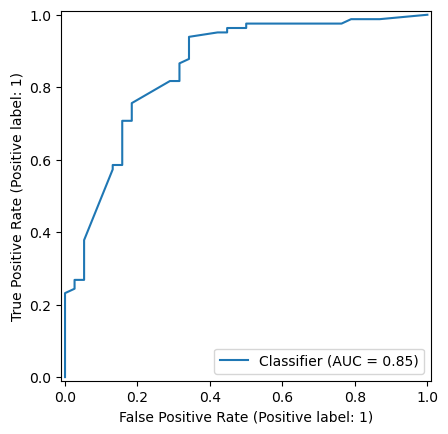

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
cal = CalibratedClassifierCV(grid.best_estimator_, cv=3, method='isotonic').fit(X_train, y_train)
proba = cal.predict_proba(X_valid)[:,1]
ths = np.linspace(0.1,0.9,33)
f1s = [f1_score(y_valid, (proba>=t).astype(int)) for t in ths]
best_th = ths[int(np.argmax(f1s))]
print('Best threshold (F1):', best_th)
RocCurveDisplay.from_predictions(y_valid, proba); plt.show()

### 6) Evaluation

In [8]:
auc = roc_auc_score(y_valid, proba)
f1 = f1_score(y_valid, (proba>=best_th).astype(int))
cm = confusion_matrix(y_valid, (proba>=best_th).astype(int))
print('Valid AUC:', auc)
print('F1 @best_th:', f1)
print('Confusion Matrix:\n', cm)

Valid AUC: 0.8538189987163028
F1 @best_th: 0.8953488372093024
Confusion Matrix:
 [[25 13]
 [ 5 77]]


### 7) Save model

In [9]:
joblib.dump(cal, 'loan_rf_calibrated.joblib')
print('Saved: loan_rf_calibrated.joblib')

Saved: loan_rf_calibrated.joblib
